# SPAM or HAM

In [3]:
import os
import math
import nltk
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 72
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models.fasttext import FastText


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/mantunes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mantunes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mantunes/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mantunes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [5]:
def div_norm(x):
   norm_value = np.linalg.norm(x)
   if norm_value > 0:
       return x * ( 1.0 / norm_value)
   else:
       return x


def word_vector_to_sentence_vector(sentence:list, model):
    vectors = []
    # for all the tokens in the setence
    for token in sentence:
        if token in model:
            vectors.append(model[token])
    # add the EOS token
    if '\n' in model:
        vectors.append(model['\n'])
    # normalize all the vectors
    vectors = [div_norm(x) for x in vectors]
    return np.mean(vectors, axis=0)

In [6]:
df = pl.read_csv('../datasets/spam.csv')
df

Target,SMS
str,str
"""ham""","""Go until juron…"
"""ham""","""Ok lar... Joki…"
"""spam""","""Free entry in …"
"""ham""","""U dun say so e…"
"""ham""","""Nah I don't th…"
"""spam""","""FreeMsg Hey th…"
"""ham""","""Even my brothe…"
"""ham""","""As per your re…"
"""spam""","""WINNER!! As a …"


In [202]:
dataset = df.rows()
dataset = [(text, label) for (label, text) in dataset]
idx = int(len(dataset)*.8)
dataset_train = dataset[0: idx]
dataset_test = dataset[idx:]

In [7]:
text_model = FastText(vector_size=256, window=7, min_count=3, workers=os.cpu_count(), seed=42)
text_model.build_vocab(tokens)

In [203]:
dataset_spam = [text for text, label in dataset if label == 'spam']
dataset_ham = [text for text, label in dataset if label == 'ham']

In [204]:
def get_frequencies(dataset, n=2):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    samples = [nltk.word_tokenize(sample) for sample in dataset]
    samples = [[lemmatizer.lemmatize(w).lower() for w in tokens if len(lemmatizer.lemmatize(w)) > n and w.isalpha() and w not in stop_words] for tokens in samples]
    samples = [token for sample in samples for token in sample]
    vocab =  list(set(samples))
    freqs = Counter(samples)

    return vocab, freqs

Counter({'get': 312, 'call': 244, 'come': 244, 'know': 242, 'got': 241, 'like': 234, 'you': 233, 'good': 226, 'time': 222, 'day': 210, 'love': 191, 'want': 182, 'need': 169, 'going': 167, 'one': 167, 'lor': 162, 'home': 160, 'how': 156, 'sorry': 155, 'still': 149, 'see': 139, 'but': 136, 'today': 135, 'later': 135, 'take': 132, 'think': 131, 'back': 129, 'dont': 127, 'tell': 123, 'send': 123, 'what': 121, 'pls': 115, 'say': 113, 'well': 113, 'night': 112, 'much': 111, 'make': 109, 'thing': 109, 'wat': 106, 'hope': 106, 'and': 106, 'happy': 104, 'great': 103, 'work': 103, 'dear': 102, 'way': 101, 'hey': 99, 'just': 97, 'give': 97, 'have': 94, 'the': 94, 'right': 91, 'already': 90, 'ask': 87, 'really': 85, 'are': 85, 'yeah': 85, 'amp': 84, 'said': 84, 'can': 82, 'wan': 81, 'phone': 81, 'let': 80, 'tomorrow': 80, 'its': 79, 'friend': 78, 'text': 77, 'would': 77, 'life': 76, 'yes': 76, 'meet': 76, 'morning': 75, 'please': 75, 'lol': 74, 'feel': 72, 'message': 72, 'that': 71, 'sure': 70, 'a

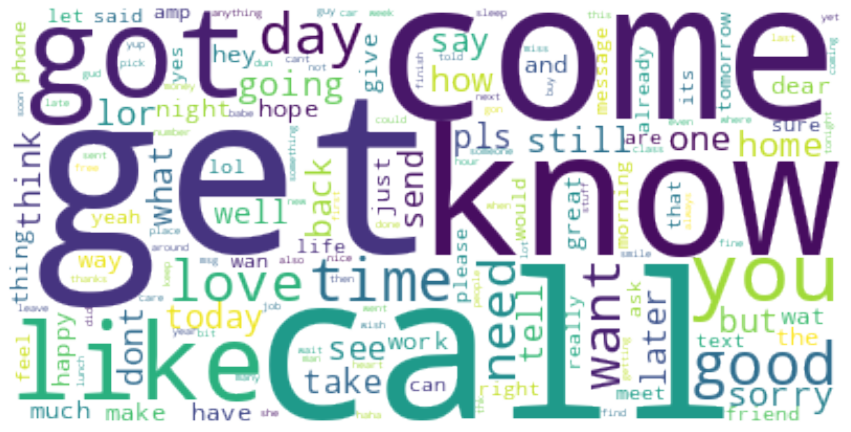

In [205]:
vocab, freqs_dict = get_frequencies(dataset_ham)

print(f'{freqs_dict}')

wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=1000)
wc.generate_from_frequencies(freqs_dict)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<Axes: xlabel='Word', ylabel='Freqs'>

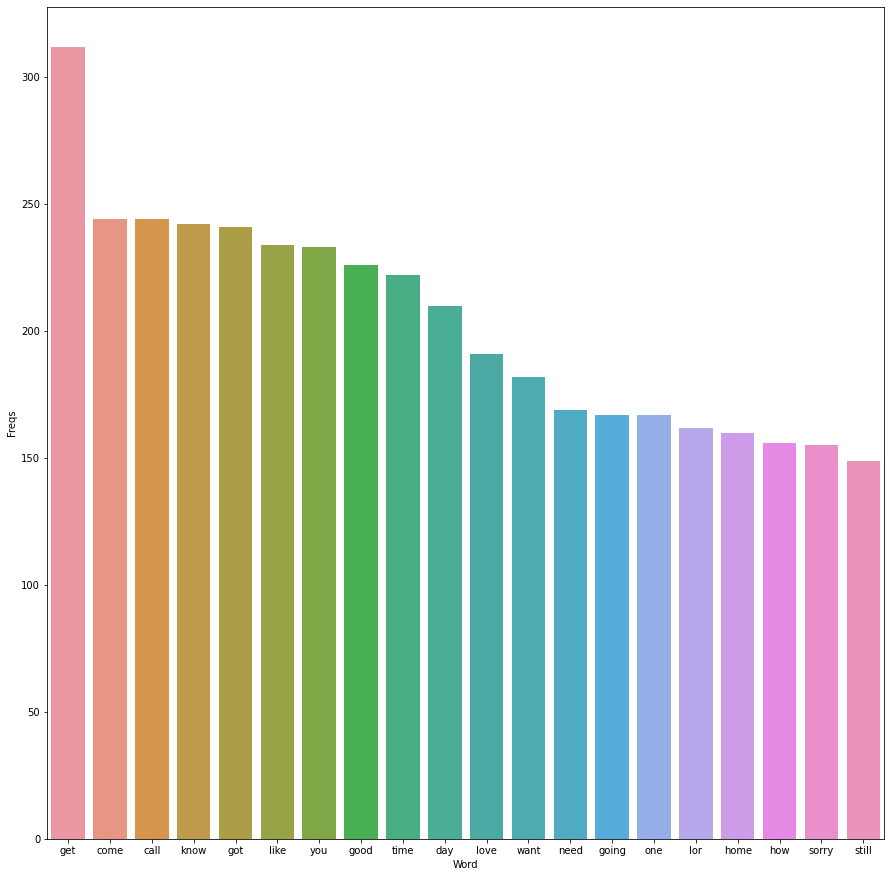

In [206]:
freqs = [freqs_dict[w] for w in vocab]

zipped_lists = zip(vocab, freqs)
sorted_pairs = sorted(zipped_lists, key=lambda t: t[1], reverse=True)
tuples = zip(*sorted_pairs)

vocab, freqs = [list(tuple) for tuple in  tuples]

df = pd.DataFrame({'Word':vocab[0:20], 'Freqs': freqs[0:20]})
sns.barplot(x='Word', y='Freqs', data=df)

Counter({'call': 353, 'free': 218, 'txt': 156, 'text': 136, 'mobile': 132, 'claim': 115, 'stop': 113, 'you': 106, 'reply': 105, 'prize': 94, 'get': 83, 'your': 75, 'new': 69, 'send': 68, 'service': 67, 'nokia': 65, 'tone': 63, 'week': 62, 'cash': 62, 'urgent': 62, 'now': 61, 'win': 60, 'phone': 57, 'contact': 56, 'please': 54, 'customer': 51, 'guaranteed': 50, 'per': 46, 'chat': 43, 'this': 42, 'min': 41, 'message': 40, 'draw': 40, 'number': 39, 'offer': 39, 'awarded': 38, 'latest': 37, 'line': 37, 'show': 35, 'landline': 34, 'receive': 33, 'camera': 33, 'msg': 33, 'voucher': 33, 'every': 33, 'holiday': 32, 'for': 32, 'rate': 31, 'want': 31, 'just': 31, 'box': 30, 'apply': 29, 'code': 29, 'chance': 29, 'live': 29, 'video': 29, 'day': 29, 'the': 28, 'ringtone': 28, 'award': 28, 'network': 27, 'entry': 26, 'orange': 26, 'collection': 26, 'word': 25, 'selected': 25, 'mob': 25, 'know': 25, 'won': 24, 'weekly': 24, 'back': 23, 'valid': 23, 'pound': 23, 'cost': 23, 'find': 23, 'collect': 23,

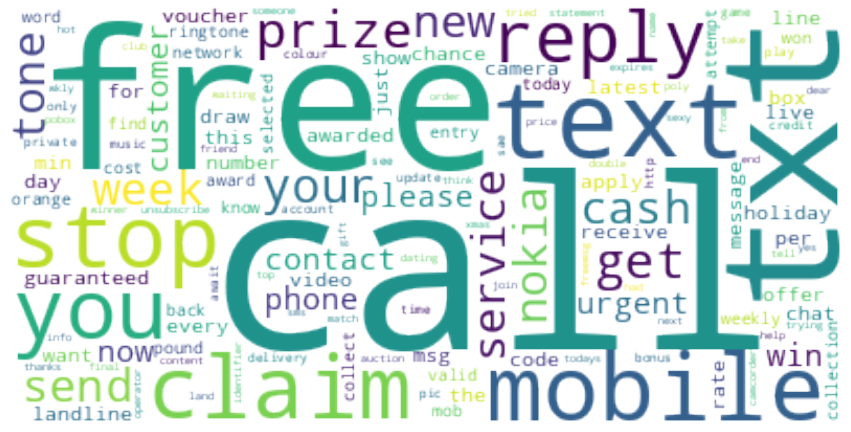

In [207]:
vocab, freqs_dict = get_frequencies(dataset_spam)

print(f'{freqs_dict}')

wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=1000)
wc.generate_from_frequencies(freqs_dict)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<Axes: xlabel='Word', ylabel='Freqs'>

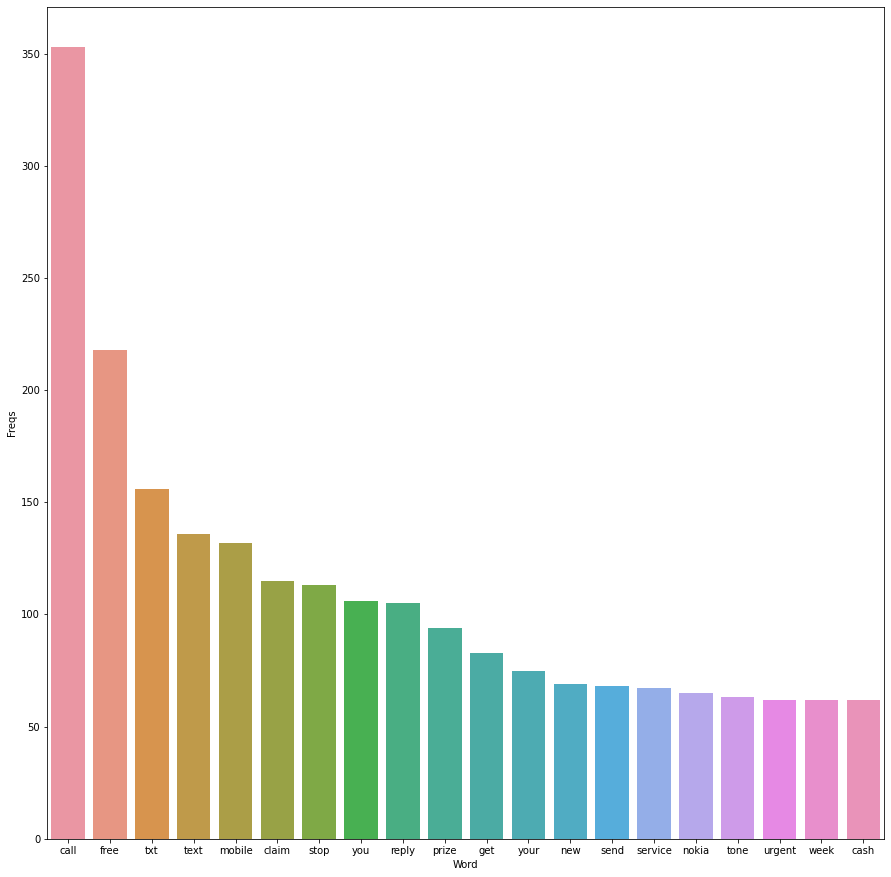

In [208]:
freqs = [freqs_dict[w] for w in vocab]

zipped_lists = zip(vocab, freqs)
sorted_pairs = sorted(zipped_lists, key=lambda t: t[1], reverse=True)
tuples = zip(*sorted_pairs)

vocab, freqs = [list(tuple) for tuple in  tuples]

df = pd.DataFrame({'Word':vocab[0:20], 'Freqs': freqs[0:20]})
sns.barplot(x='Word', y='Freqs', data=df)

Counter({'call': 597, 'get': 395, 'you': 339, 'free': 277, 'know': 267, 'come': 249, 'got': 248, 'like': 247, 'time': 241, 'day': 239, 'good': 238, 'text': 213, 'want': 213, 'love': 201, 'send': 191, 'need': 180, 'one': 177, 'going': 171, 'txt': 169, 'home': 162, 'lor': 162, 'how': 161, 'sorry': 158, 'today': 157, 'see': 157, 'still': 156, 'back': 152, 'stop': 151, 'take': 150, 'mobile': 147, 'reply': 146, 'think': 145, 'tell': 141, 'dont': 138, 'phone': 138, 'but': 136, 'new': 135, 'later': 135, 'week': 131, 'please': 129, 'just': 128, 'what': 125, 'pls': 125, 'the': 122, 'make': 122, 'night': 119, 'well': 118, 'dear': 118, 'claim': 115, 'great': 114, 'your': 114, 'say': 113, 'message': 112, 'much': 112, 'thing': 112, 'hope': 110, 'and': 109, 'wat': 107, 'number': 107, 'work': 106, 'happy': 105, 'hey': 104, 'give': 104, 'way': 102, 'have': 101, 'this': 96, 'friend': 94, 'prize': 94, 'right': 94, 'msg': 94, 'now': 93, 'wan': 93, 'already': 91, 'yes': 91, 'tomorrow': 90, 'are': 88, 'ask

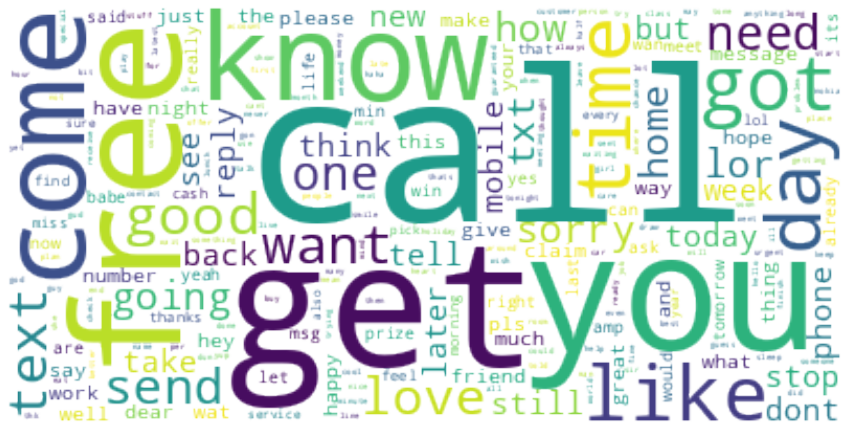

In [209]:
dataset_no_label = [text for text, _ in dataset]
vocab, freqs_dict = get_frequencies(dataset_no_label)

print(f'{freqs_dict}')

wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=1000)
wc.generate_from_frequencies(freqs_dict)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<Axes: xlabel='Word', ylabel='Freqs'>

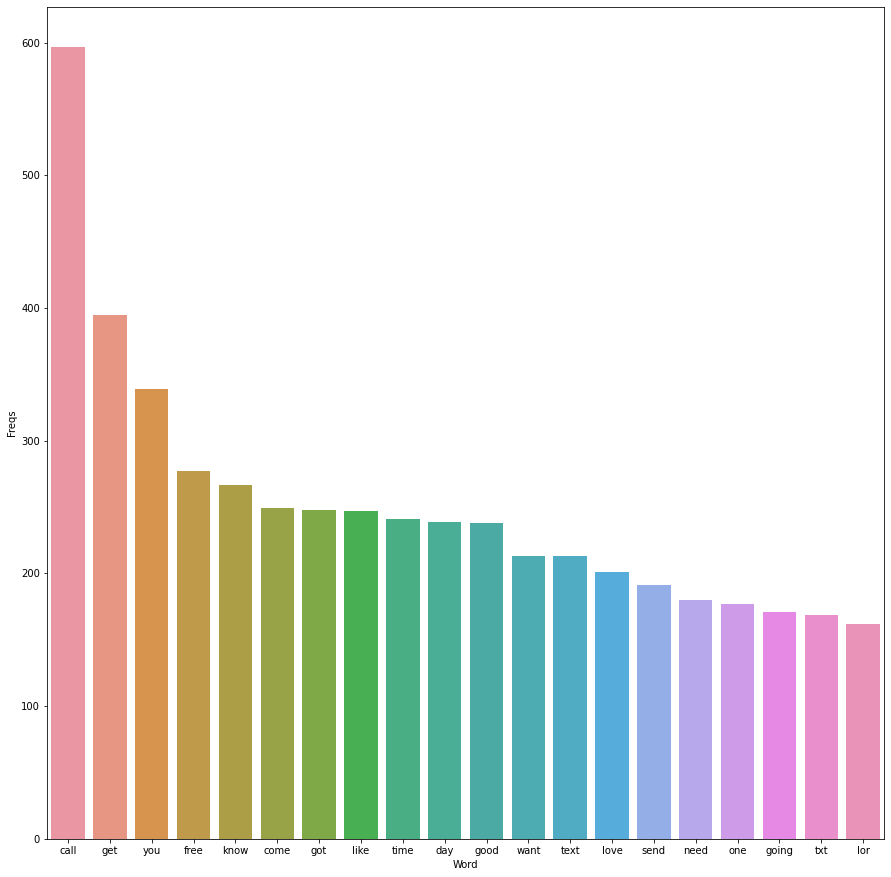

In [210]:
freqs = [freqs_dict[w] for w in vocab]

zipped_lists = zip(vocab, freqs)
sorted_pairs = sorted(zipped_lists, key=lambda t: t[1], reverse=True)
tuples = zip(*sorted_pairs)

vocab, freqs = [list(tuple) for tuple in  tuples]

df = pd.DataFrame({'Word':vocab[0:20], 'Freqs': freqs[0:20]})
sns.barplot(x='Word', y='Freqs', data=df)

## Select Vocabulary

In [211]:
def get_tfidf(dataset, n=2):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    samples = [nltk.word_tokenize(sample) for sample in dataset]
    samples = [[lemmatizer.lemmatize(w).lower() for w in tokens if len(lemmatizer.lemmatize(w)) > n and w.isalpha() and w not in stop_words] for tokens in samples]
    samples_flat = [token for sample in samples for token in sample]
    vocab =  list(set(samples_flat))
    tf = Counter(samples_flat)
    for k in vocab:
        tf[k] /= len(dataset)
    
    idf = {}
    for k in vocab:
        number_documents_word = 0
        for d in samples:
            if k in d:
                number_documents_word += 1
        idf[k] = math.log(len(dataset)/(number_documents_word+1))

    tfidf = {}
    for k in vocab:
        tfidf[k] = tf[k] * idf[k]

    return vocab, tfidf

{'guess': 0.03480709260978704, 'transfred': 0.0014350963777801304, 'function': 0.002723311716578857, 'marriage': 0.008457313699076457, 'bulb': 0.002723311716578857, 'box': 0.03190506014018796, 'wrkin': 0.0014350963777801304, 'mobilesdirect': 0.003928646941404177, 'mth': 0.0014350963777801304, 'yet': 0.042603615983118084, 'pop': 0.003928646941404177, 'tai': 0.0014350963777801304, 'nipost': 0.0014350963777801304, 'hor': 0.002723311716578857, 'samachara': 0.0014350963777801304, 'musical': 0.0014350963777801304, 'unbreakable': 0.002723311716578857, 'twilight': 0.002723311716578857, 'fools': 0.0014350963777801304, 'recreation': 0.0014350963777801304, 'surprise': 0.013152758394832475, 'waliking': 0.0014350963777801304, 'realised': 0.0014350963777801304, 'confuses': 0.002723311716578857, 'qatar': 0.005076526984133269, 'entertaining': 0.0014350963777801304, 'door': 0.012216171700318147, 'commercial': 0.002723311716578857, 'huiming': 0.0014350963777801304, 'hair': 0.024018569805147164, 'century

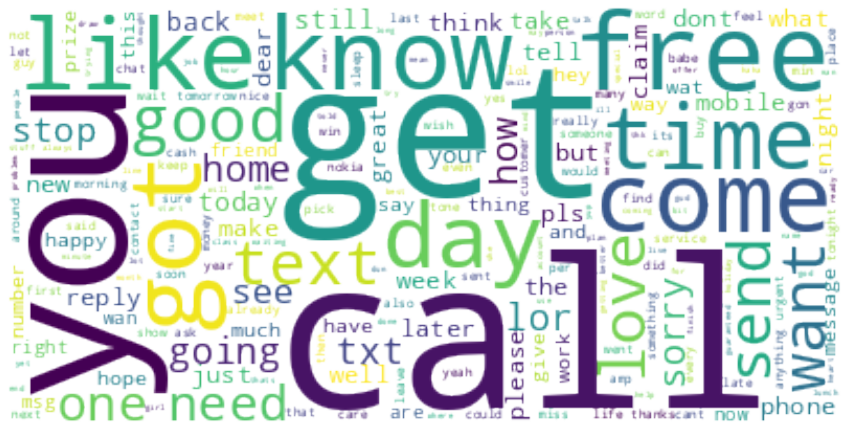

In [212]:
dataset_no_label = [text for text, _ in dataset]
vocab, tfidf_dict = get_tfidf(dataset_no_label)

print(f'{tfidf_dict}')

wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=1000)
wc.generate_from_frequencies(tfidf_dict)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<Axes: xlabel='Word', ylabel='TFIDF'>

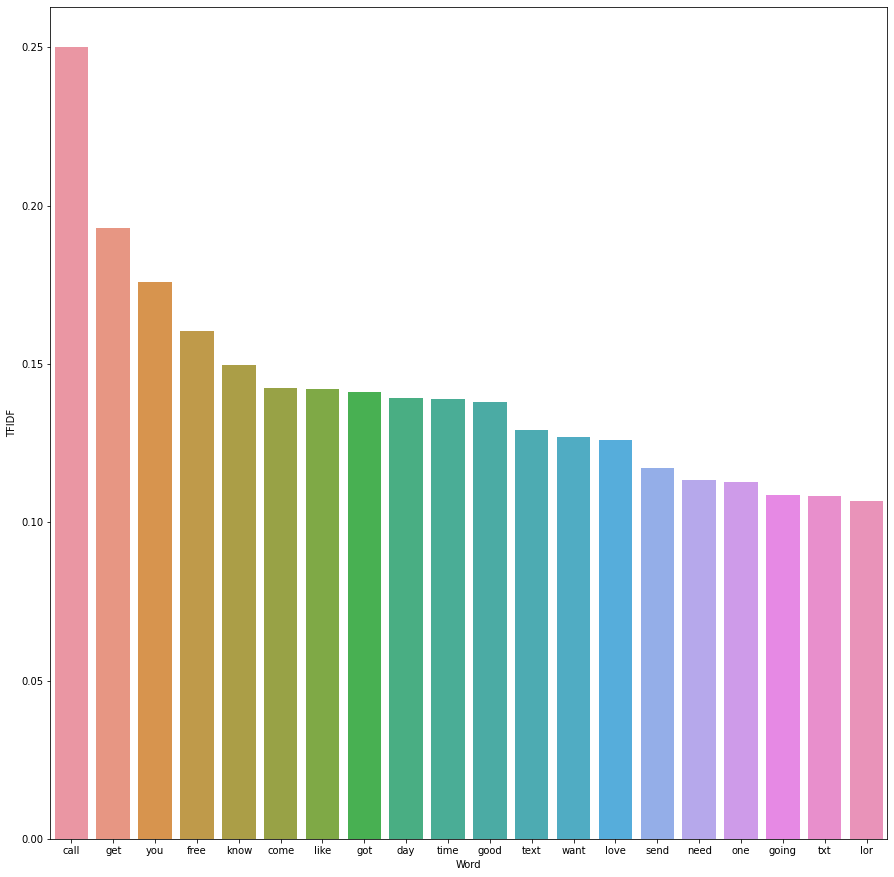

In [213]:
tfidf = [tfidf_dict[w] for w in vocab]

zipped_lists = zip(vocab, tfidf)
sorted_pairs = sorted(zipped_lists, key=lambda t: t[1], reverse=True)
tuples = zip(*sorted_pairs)

vocab, tfidf = [list(tuple) for tuple in  tuples]

df = pd.DataFrame({'Word':vocab[0:20], 'TFIDF': tfidf[0:20]})
sns.barplot(x='Word', y='TFIDF', data=df)

In [214]:
selected_vocab = vocab[0:256]
#lemmatizer = WordNetLemmatizer()
#stop_words = set(nltk.corpus.stopwords.words('english'))
#dataset_no_label = [text for text, _ in dataset]
#samples = [nltk.word_tokenize(sample) for sample in dataset_no_label]
#samples = [[lemmatizer.lemmatize(w).lower() for w in tokens if len(lemmatizer.lemmatize(w)) > 2] for tokens in samples]
#samples = [token for sample in samples for token in sample]
#vocab =  list(set(samples))

## Train NB model

In [215]:
class NB:
    def __init__(self, k=1, n=2):
        self.k = k
        self.n = n
        self.lemmatizer = WordNetLemmatizer()
    
    def _vocab(self, samples):
        vocab = [token for sample in samples for token in sample]
        #print(f'{samples}/{vocab}')
        return list(set(vocab))

    def _compute_likelihood(self, samples):
        likelihood = {}
        vocab = self._vocab(samples)
        
        for w in vocab:
            count = 0
            for sentence in samples:
                if w in sentence:
                    #print(w+":", sentence)
                    count += 1
            #print(f"Number of ham emails with the word '{w}': {count}")
            #prob = (count + self.k)/(len(samples) + 2.0*self.k) # smoothing
            #print(f"Probability of the word '{w}': {prob} ")
            likelihood[w.lower()] = count
        return likelihood
    
    def _p_word_spam(self, token):
        return (self.k + self.likelihood_spam.get(token, 0.0)) / ((2.0 * self.k) + self.num_spam_messages)

    def _p_word_ham(self, token):
        return (self.k + self.likelihood_ham.get(token, 0.0)) / ((2.0 * self.k) + self.num_ham_messages)

    def train(self, dataset, selected_vocab):
        #print(f'{selected_vocab}')
        
        # compute priors
        dataset_total = len(dataset)
        spam_samples = [txt for txt, label in dataset if label == 'spam']
        ham_samples = [txt for txt, label in dataset if label == 'ham']

        #print(f'{spam_samples}')
        #print(f'{ham_samples}')

        self.ps = len(spam_samples) / dataset_total
        self.ph = len(ham_samples) / dataset_total

        #print(f'{self.ps} {self.ph}')

        # Pre-process text
        spam_samples = [nltk.word_tokenize(sample) for sample in spam_samples]
        ham_samples = [nltk.word_tokenize(sample) for sample in ham_samples]

        #print(f'{spam_samples}')
        #print(f'{ham_samples}')

        #spam_samples = [[self.lemmatizer.lemmatize(w).lower() for w in tokens if len(self.lemmatizer.lemmatize(w)) > 2] for tokens in spam_samples]
        #ham_samples = [[self.lemmatizer.lemmatize(w).lower() for w in tokens if len(self.lemmatizer.lemmatize(w)) > 2] for tokens in ham_samples]
        spam_samples = [[self.lemmatizer.lemmatize(w).lower() for w in tokens if self.lemmatizer.lemmatize(w) in selected_vocab] for tokens in spam_samples]
        ham_samples = [[self.lemmatizer.lemmatize(w).lower() for w in tokens if self.lemmatizer.lemmatize(w) in selected_vocab] for tokens in ham_samples]
        
        #print(f'{spam_samples}')
        #print(f'{ham_samples}')

        # compute_likelihood
        self.likelihood_spam = self._compute_likelihood(spam_samples)
        self.num_spam_messages = len(spam_samples)
        self.likelihood_ham = self._compute_likelihood(ham_samples)
        self.num_ham_messages = len(ham_samples)

        #print(f'{self.likelihood_spam}')
        #print(f'{self.likelihood_ham}')
    
    def predict(self, txt):
        # Pre-process text (similar to the train)
        tokens = nltk.word_tokenize(txt)
        tokens = [self.lemmatizer.lemmatize(w).lower() for w in tokens if len(self.lemmatizer.lemmatize(w)) > self.n and w.isalpha() and w not in set(nltk.corpus.stopwords.words('english'))]

        log_p_spam = 0.0
        log_p_ham = 0.0

        for t in tokens:
            log_p_spam += math.log(self._p_word_spam(t))
            log_p_ham += math.log(self._p_word_ham(t))
        
        prob_spam = (math.exp(log_p_spam)*self.ps)/(math.exp(log_p_spam)*self.ps+math.exp(log_p_ham)*self.ph)
        if prob_spam >= 0.5:
            return 'spam', prob_spam
        else:
            return 'ham', prob_spam

In [216]:
clf = NB()
clf.train(dataset_train, vocab)

In [217]:
acc = 0.0
for sentence, label in dataset_train:
    predicted_label, prob_spam = clf.predict(sentence)
    #print(f'{sentence} -> {predicted_label} {prob_spam}')
    if label == predicted_label:
        acc += 1.0
print(f'Accuracy = {acc/len(dataset_train)}')

Accuracy = 0.8136322463768116


In [218]:
acc = 0.0
for sentence, label in dataset_test:
    predicted_label, prob_spam = clf.predict(sentence)
    #print(f'{sentence} -> {predicted_label} {prob_spam}')
    if label == predicted_label:
        acc += 1.0
print(f'Accuracy = {acc/len(dataset_test)}')

Accuracy = 0.7330316742081447
